In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [21]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import sophius.utils as utils
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
from sophius.train import train_express_gpu
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder


VAL_SIZE = 1024

cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=T.ToTensor())
cifar_gpu = dload.cifar_to_gpu(cifar10)
loader_gpu = dload.get_loader_gpu(cifar_gpu, val_size=VAL_SIZE, batch_size=1024)

encoder = Encoder()

Files already downloaded and verified


In [3]:
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()  # Put the model in test mode (the opposite of model.train(), essentially)
    with torch.no_grad():
        for x, y in loader:
            x_var = x.type(torch.cuda.FloatTensor)
            y_var = y.type(torch.LongTensor)
            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y_var).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
#     print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc


def check_accuracy_gpu(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()  # Put the model in test mode (the opposite of model.train(), essentially)
    with torch.no_grad():
        for x, y in loader:
            scores = model(x)
            _, preds = scores.data.cuda().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
#     print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_express_gpu(model=None,
                      loader=None,
                      num_epoch=1,
                      milestones=None,
                      train=False,
                      manual_seed=False,
                      verbose=False):
    if milestones is None:
        milestones = []

    start_time = time.time()
    
    if manual_seed:
        torch.cuda.random.manual_seed(12345)
    # init
    loss_fn = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    model.apply(utils.reset)
    model.train()

    train_acc, val_acc = 0, 0

    res = pd.DataFrame(columns=['epoch', 'train_acc', 'val_acc', 'time'])

    for i in range(num_epoch):
        model.train()
        for t, (x, y) in enumerate(loader['train']):
            scores = model(x)
            loss = loss_fn(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        
        _val_acc = check_accuracy(model, loader['val'])
        _train_acc = check_accuracy(model, loader['train_small'])
        res.loc[i] = [i, _train_acc, _val_acc, time.time() - start_time]
        
        
    val_acc = check_accuracy(model, loader['val'])
    if train: 
        train_acc = check_accuracy(model, loader['train_small'])

    time_elapsed = (time.time() - start_time)

    if verbose:
        print ('Finished in %s' % utils.format_time(time_elapsed))
        print('val_acc: %.3f, train_acc: %.3f' % (val_acc, train_acc))
    
    torch.cuda.empty_cache()
    del model
    
    return res

In [4]:
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=6, lin_num=3)

model_tmpl = model_gen.generate_model_tmpl()
model = model_tmpl.instantiate_model(gpu=True)

In [5]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(3, 3), padding=(3, 3))
  (1): LeakyReLU(negative_slope=0.1)
  (2): MaxPool2d(kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), dilation=(1, 1), ceil_mode=False)
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): AvgPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=64, out_features=1024, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=1024, out_features=256, bias=True)
  (10): PReLU(num_parameters=1)
  (11): Linear(in_features=256, out_features=10, bias=True)
)

In [14]:
import sqlite3
import pandas as pd
from sophius.encode import Encoder
encoder = Encoder()


with sqlite3.connect('../data/models.db') as conn:
    df = pd.read_sql('SELECT * FROM conv_10_lin_3_epoch_50', conn)


model_id = 310
t = encoder.hash2model(df.loc[model_id, 'hex_str'], in_shape=(3, 32, 32), out_shape=10)         
model = t.instantiate_model(gpu=True)
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2))
  (1): LeakyReLU(negative_slope=0.1)
  (2): AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=5408, out_features=1024, bias=True)
  (5): LeakyReLU(negative_slope=0.001)
  (6): Dropout(p=0.75, inplace=False)
  (7): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
from sophius.train import train_on_gpu

# Explore val_size and batch_size

Loss 51.248: 100%|██████████| 50/50 [02:34<00:00,  3.09s/it] 


max_val_acc: 0.660 val_acc: 0.630 train_acc: 0.982


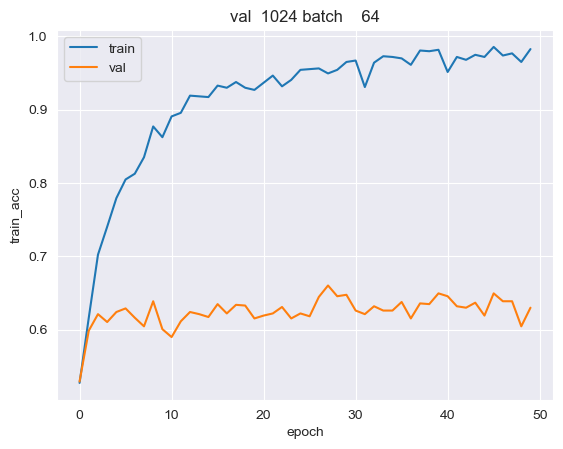

In [45]:
val_size = 1024
batch_size = 64

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 16.258: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it] 


max_val_acc: 0.648 val_acc: 0.630 train_acc: 0.949


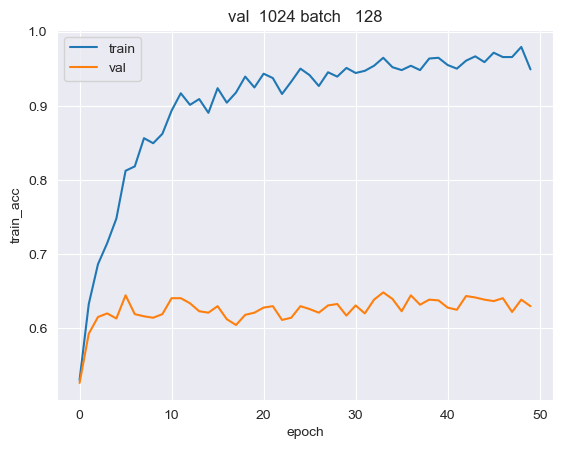

In [44]:
val_size = 1024
batch_size = 128

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 4.839: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]  


max_val_acc: 0.635 val_acc: 0.604 train_acc: 0.961


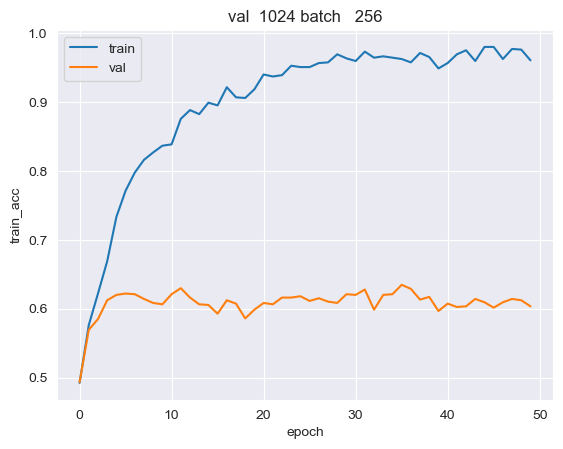

In [43]:
val_size = 1024
batch_size = 256

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 0.430: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s] 


max_val_acc: 0.662 val_acc: 0.646 train_acc: 0.991


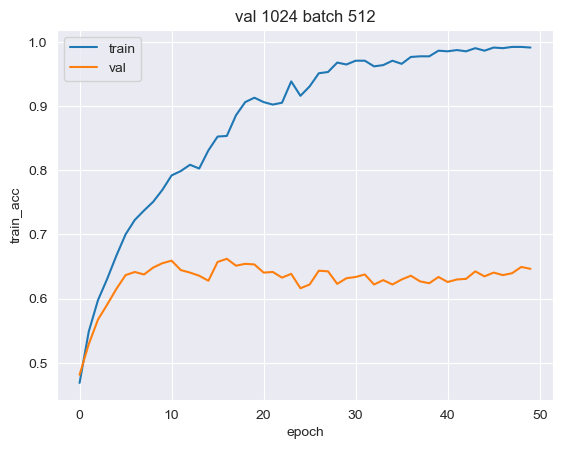

In [42]:
val_size = 1024
batch_size = 512

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 4.046: 100%|██████████| 50/50 [00:22<00:00,  2.26it/s] 


max_val_acc: 0.663 val_acc: 0.639 train_acc: 0.981


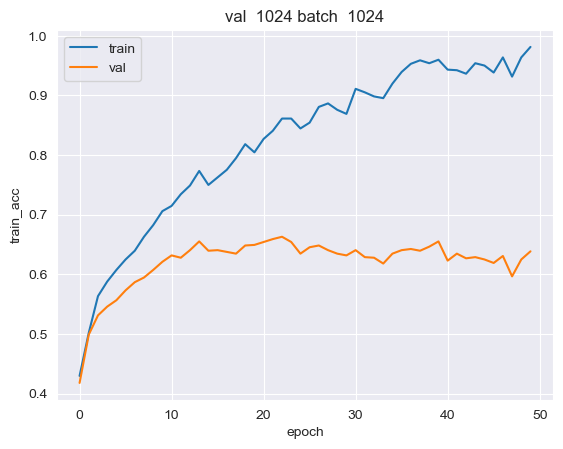

In [41]:
val_size = 1024
batch_size = 1024

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 4.054: 100%|██████████| 50/50 [00:22<00:00,  2.26it/s] 


max_val_acc: 0.656 val_acc: 0.627 train_acc: 0.948


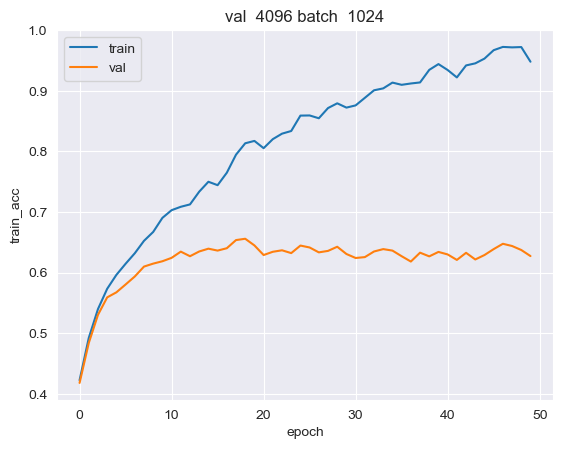

In [46]:
val_size = 4096
batch_size = 1024

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 2.945: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s] 


max_val_acc: 0.627 val_acc: 0.624 train_acc: 0.981


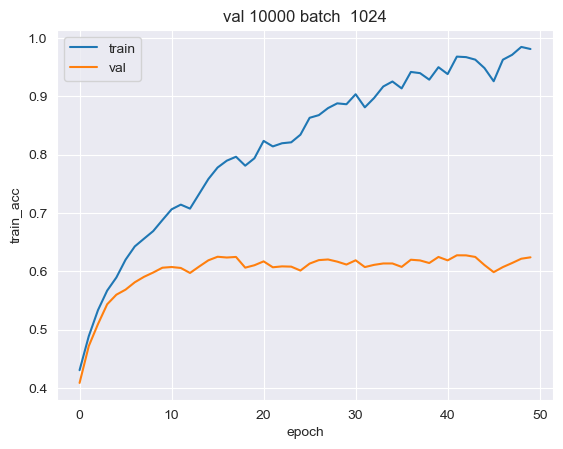

In [47]:
val_size = 10000
batch_size = 1024

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 3.465: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s] 


max_val_acc: 0.630 val_acc: 0.619 train_acc: 0.969


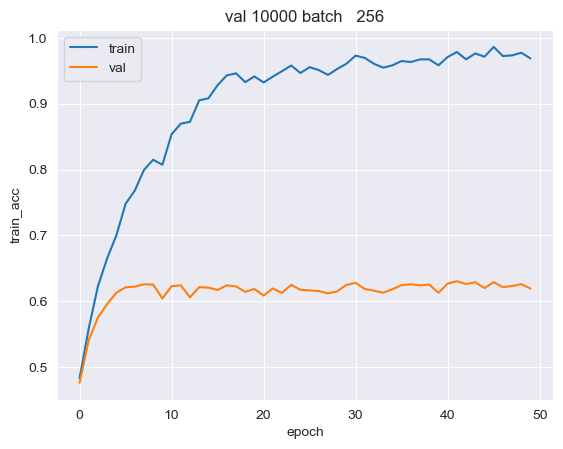

In [49]:
val_size = 10000
batch_size = 256

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 37.135: 100%|██████████| 50/50 [02:17<00:00,  2.76s/it] 


max_val_acc: 0.627 val_acc: 0.611 train_acc: 0.968


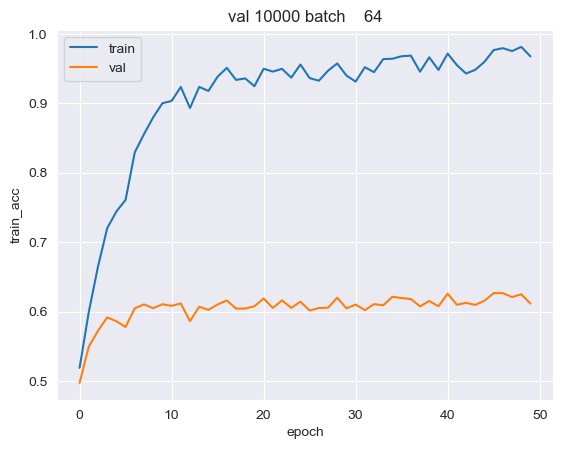

In [48]:
val_size = 10000
batch_size = 64

res = train_on_gpu(
    model = model,                  
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

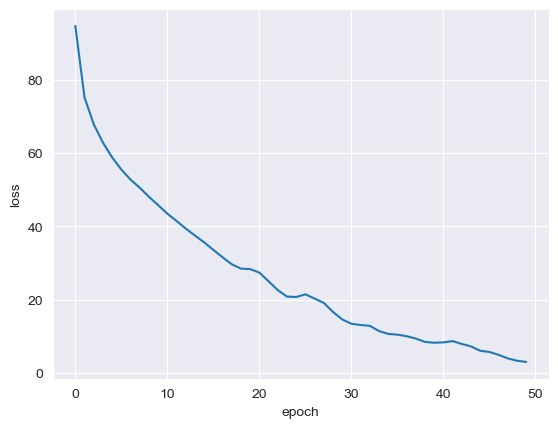

In [9]:
sns.lineplot(res, x = 'epoch', y = 'loss');

# Check different models

In [54]:
df.sort_values(by='val_acc', ascending=False, inplace=True)
df

,hex_str,flops,macs,params,time,val_acc,train_acc
930,0080842220000000400000000080412108040000400000...,961733248,480408512,2003755,613.818239,0.813477,0.994141
302,0082082140000000200000000080209210040000008088...,275556800,137555328,824188,258.427490,0.787109,0.976562
23,0082082100491000080800000022c80000802052004920...,48945472,24390976,1144731,177.061507,0.755859,0.996094
763,0080482110080000004910004000000000295000008022...,212892960,106029648,561683,282.491944,0.752930,0.877930
310,0082009110080000002928000100000080004000100200...,12470656,6225408,5552554,13.457602,0.726562,0.918945
...,...,...,...,...,...,...,...
208,0084020508080000008050061004000000821009004260...,21729184,10858496,10761994,164.906045,0.195312,0.284180
129,0080500608040000400000000028b00000449000001000...,448672,200704,181035,16.418530,0.192383,0.167969
115,0082011210080000400000000023480000880061200000...,4776752,2363776,92251,29.879237,0.176758,0.184570
408,0088010520000000400000000028c80000802805200000...,403224,199384,172922,15.385370,0.169922,0.196289


In [57]:
t = encoder.hash2model(df.iloc[0]['hex_str'], in_shape=(3, 32, 32), out_shape=10)         
model = t.instantiate_model(gpu=True)
model

Sequential(
  (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1))
  (4): PReLU(num_parameters=1)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(128, 192, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (7): LeakyReLU(negative_slope=0.01)
  (8): AvgPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(192, 64, kernel_size=(1, 1), stride=(3, 3))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): AvgPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): PReLU(num_parameters=64)
  (13): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (14): LeakyReLU(negative_slope=0.1)
  (15): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (16): Conv2d(128, 96, ker

In [ ]:
val_size = 10000
batch_size = 256

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');

Loss 62.554:  28%|██▊       | 14/50 [04:43<12:08, 20.24s/it]

In [ ]:
t = encoder.hash2model(df.iloc[0]['hex_str'], in_shape=(3, 32, 32), out_shape=10)         
model = t.instantiate_model(gpu=True)

val_size = 10000
batch_size = 256

res = train_on_gpu(
    model = model,
    loader = dload.get_loader_gpu(cifar_gpu, val_size=val_size, batch_size=batch_size),
    milestones = [],
    num_epoch = 50,
    verbose = True
)

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val')
plt.title(f'val {val_size:5d} batch {batch_size:5d}');